# 2. Linear Regression Analysis

## Setup

In [254]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline 

In [210]:
# Load data
data = pd.read_csv('data/Ames_Housing_Price_Data_encoded.csv')

In [211]:
# Create the independent variables and the target
predictors = data.drop('SalePrice', axis=1)
target = data['SalePrice']

In [212]:
print(predictors.columns.sort_values())

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley_None', 'Alley_Pave',
       'BedroomAbvGr', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs',
       'BldgType_TwnhsE',
       ...
       'SaleType_WD ', 'ScreenPorch', 'Street_Pave', 'TotRmsAbvGrd',
       'TotalBsmtSF', 'Utilities_NoSewr', 'WoodDeckSF', 'YearsSinceBuilt',
       'YearsSinceRemod', 'YrSold'],
      dtype='object', length=243)


## Key Assumptions of Linear Regression

Linear Regression has several key assumptions:
1. **Linearity** - there should be a linear relationship between the independent (predictor) variables and the dependent (response) variable
2. **Independence of Errors** - residuals should be independent of each other with no correlation
3. **Homoscedasticity** - residuals should have constant variance across the range of predicted values
4. **Normality of errors** - residuals should be approximiately normally distributed
5. **No or little multicollinearity** - independent variables should not be highly correlated with each other

## Check for Multicollinearity

We will check for multicollinearity first given the large number of features

In [215]:
# Get the numeric or ordinal categorical variables prior to one-hot encoding
num_ord_cols = ['GrLivArea',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'NeighborhoodCostIndex',
 'YearsSinceBuilt',
 'YearsSinceRemod',
 'Crisis']

In [216]:
# Select only these columns
predictors_num_ord = predictors[num_ord_cols]

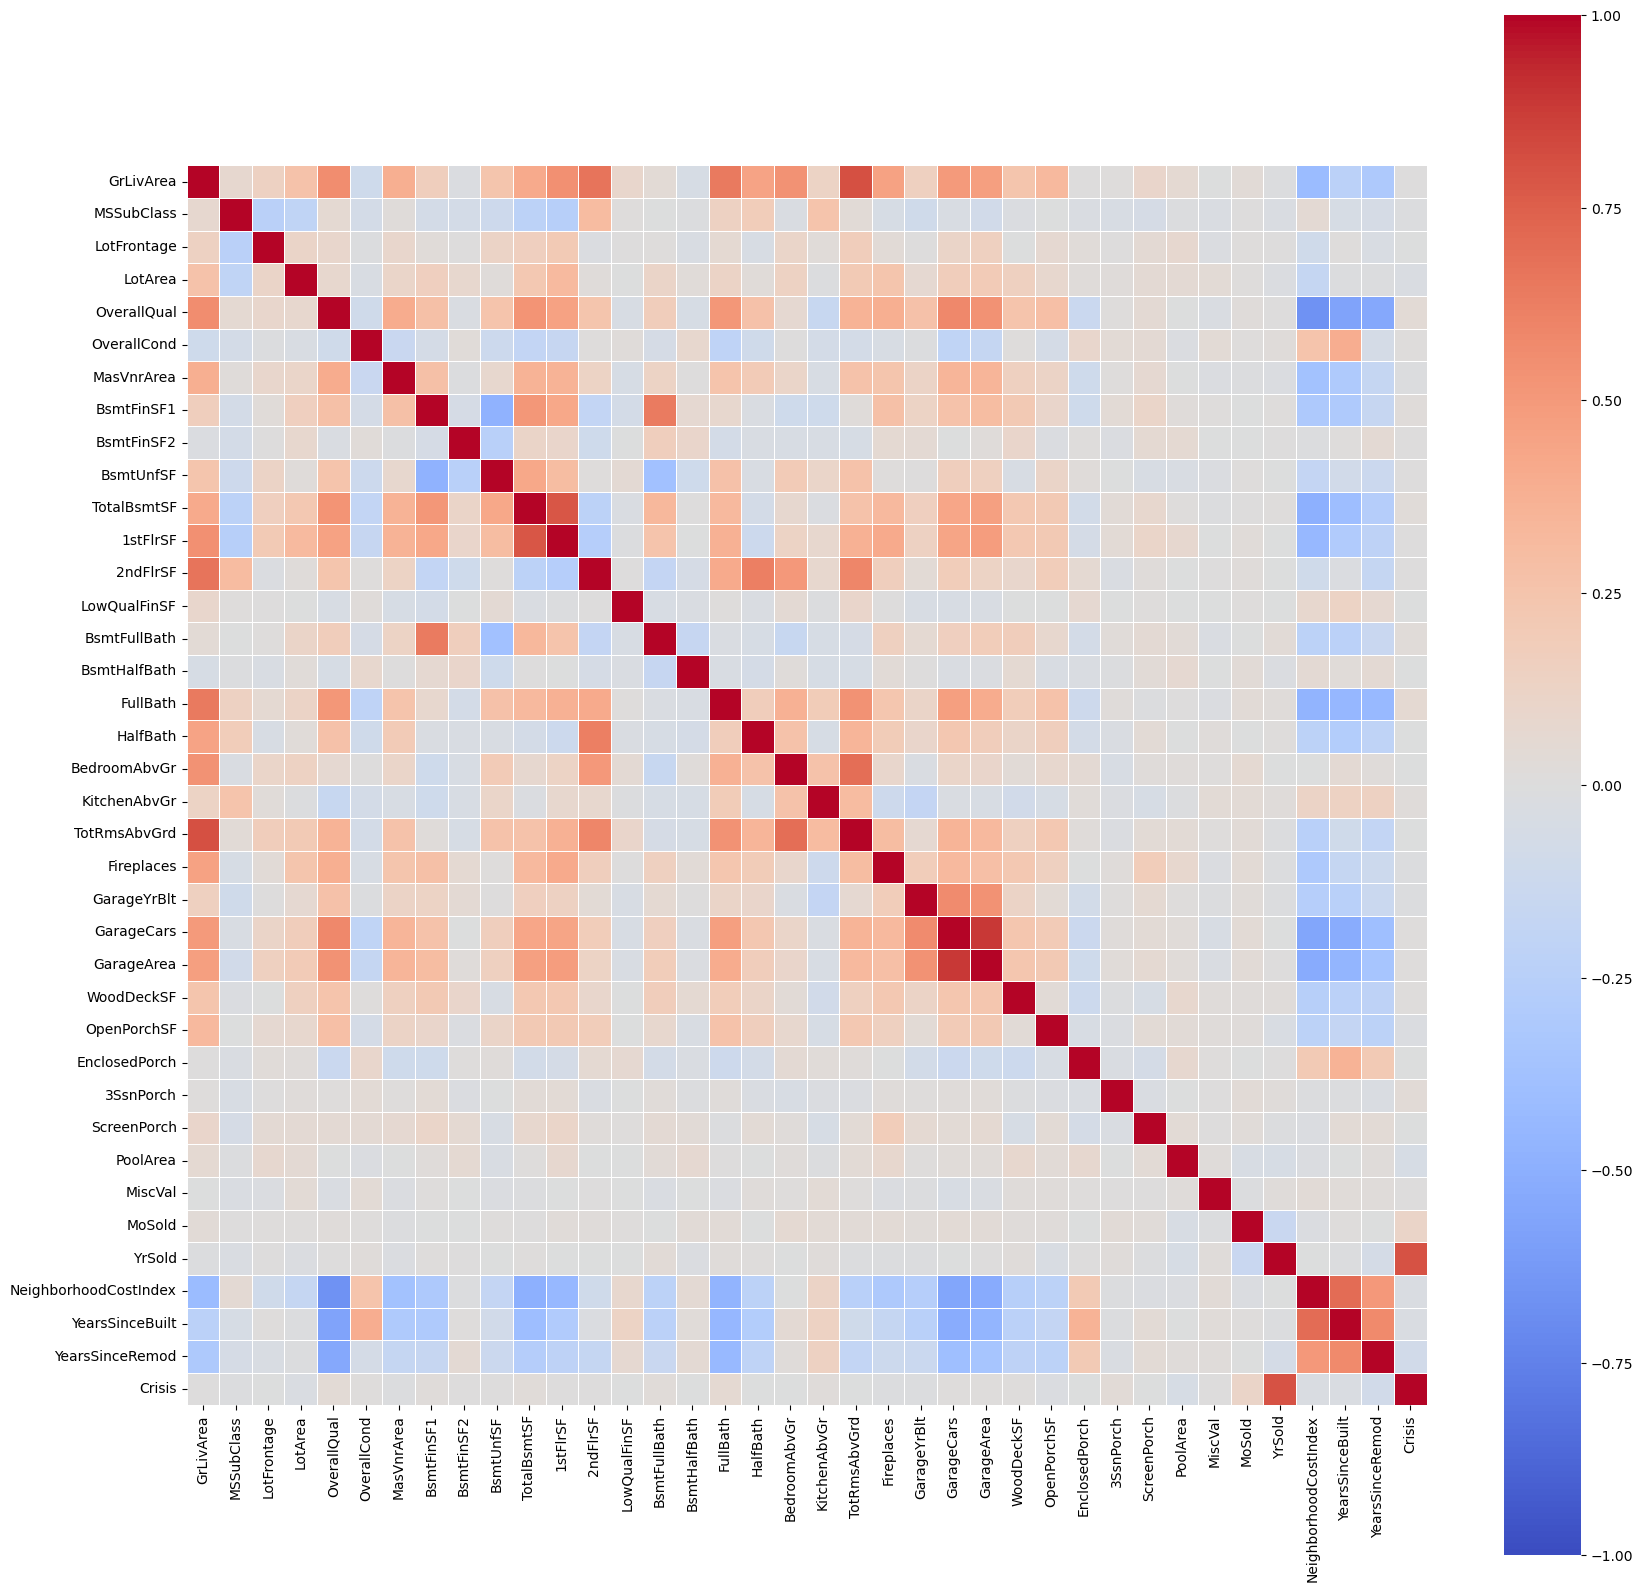

In [217]:
# Plot the correlation matrix
correlation_matrix = predictors_num_ord.corr()

plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, square=True, cmap='coolwarm', fmt='.2f', vmax=1.0, vmin=-1.0, linewidths=0.5)
plt.show()

In [218]:
# Calculate the variance inflation factor (VIF) for each independent variable
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(predictors_num_ord.values, i) 
              for i in range(predictors_num_ord.shape[1])]

# Print the column names and their VIF values
vif = vif.assign(Feature=predictors_num_ord.columns)
vif.sort_values(by='VIF', ascending=False, inplace=True)
print(vif)

           VIF                Feature
0          inf              GrLivArea
11         inf               1stFlrSF
13         inf           LowQualFinSF
12         inf               2ndFlrSF
7          inf             BsmtFinSF1
8          inf             BsmtFinSF2
9          inf              BsmtUnfSF
10         inf            TotalBsmtSF
33  185.499069                 YrSold
20   81.936323           TotRmsAbvGrd
4    64.930046            OverallQual
19   43.547368           KitchenAbvGr
5    41.303074            OverallCond
23   40.805807             GarageCars
22   33.760592            GarageYrBlt
24   32.697767             GarageArea
18   31.802018           BedroomAbvGr
16   25.406999               FullBath
34   14.899796  NeighborhoodCostIndex
35   11.441772        YearsSinceBuilt
32    6.503901                 MoSold
36    5.792820        YearsSinceRemod
2     4.396031            LotFrontage
1     4.290326             MSSubClass
14    3.632828           BsmtFullBath
17    3.4608

/Users/georgeho/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


## Feature Selection

Given the significant presence of multicollinearity, we will build the feature set "bottoms up."  One way to do that is relying upon domain expertise.

See:  https://www.opendoor.com/articles/factors-that-influence-home-value

This article lists several features that "conventional wisdom" deems important in determining a home's value:
1. Location
2. Home size and usable space
3. Age and condition
4. Upgrades and updates
5. The local market
6. Economic indicators
7. Interest rates

We will look for proxy variables in the dataset for each one, testing for (a) predictive performance and (b) minimization of multicollinearity on the whole set.

In [219]:
# Create linear regression object
lr = LinearRegression()

#### Location proxy features

*Candidates:*
- NeighborhoodCostIndex: Physical locations within Ames city limits, ranked by costliness of neighborhood
- Condition1: Proximity to various conditions (dummified)

In [220]:
# NeighborhoodCostIndex

# Fit the model
lr.fit(predictors[['NeighborhoodCostIndex']], target)

# Show the R^2 score
lr.score(predictors[['NeighborhoodCostIndex']], target)

0.4978140115013281

In [275]:
# Condition1 (dummified)

# Gather the dummified columns
condition1_cols = [col for col in predictors.columns if 'Condition1' in col]
print(condition1_cols)

# Fit the model
lr.fit(predictors[condition1_cols], target)

# Show the R^2 score
lr.score(predictors[condition1_cols], target)

['Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn']


0.045311043746464774

#### Home Size and Usable Space proxy features

*Candidates:*
- LotArea: Lot size in square feet
- GrLivArea: Above grade (ground) living area square feet
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

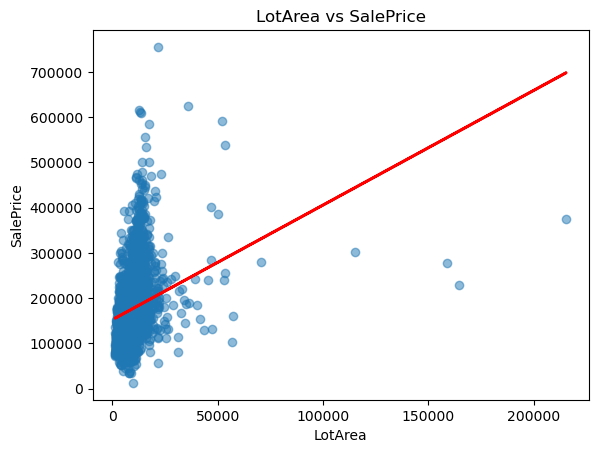

R^2 = 0.07531013997565805


In [221]:
# Plot and score LotArea

# Fit the model
lr.fit(predictors[['LotArea']], target)

# Create scatter plot
plt.scatter(predictors['LotArea'], target, alpha=0.5)

# Plot the regression line
plt.plot(predictors['LotArea'], lr.predict(predictors[['LotArea']]), color='red', linewidth=2)

# Label the plot
plt.title('LotArea vs SalePrice')
plt.xlabel('LotArea')
plt.ylabel('SalePrice')

# Show the plot
plt.show()

# Show scores
print(f"R^2 = {lr.score(predictors[['LotArea']], target)}")

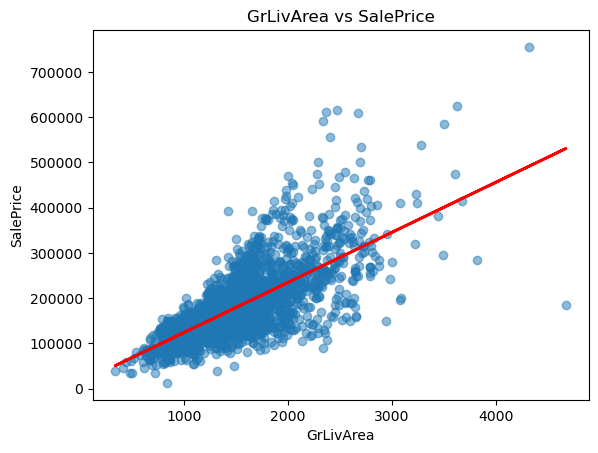

R^2 = 0.5183711142112821


In [222]:
# Plot and score GrLivArea

# Fit the model
lr.fit(predictors[['GrLivArea']], target)

# Create scatter plot
plt.scatter(predictors['GrLivArea'], target, alpha=0.5)

# Plot the regression line
plt.plot(predictors['GrLivArea'], lr.predict(predictors[['GrLivArea']]), color='red', linewidth=2)

# Label the plot
plt.title('GrLivArea vs SalePrice')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

# Show the plot
plt.show()

# Show scores
print(f"R^2 = {lr.score(predictors[['GrLivArea']], target)}")

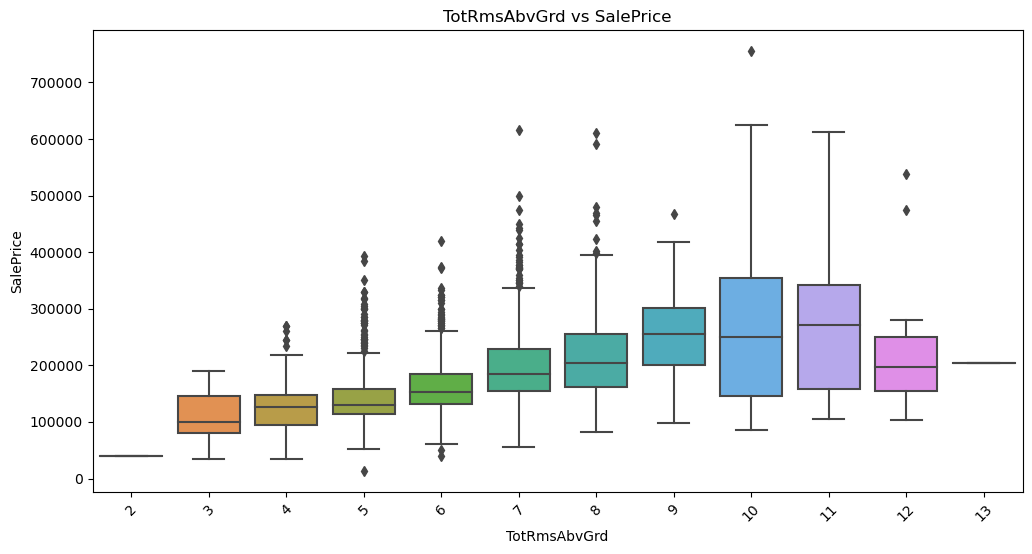

In [223]:
# Create a box plot of SalePrice vs. TotRmsAbvGrd
plt.figure(figsize=(12, 6))
sns.boxplot(x='TotRmsAbvGrd', y='SalePrice', data=ames_clean)

# Label the plot
plt.title('TotRmsAbvGrd vs SalePrice')
plt.xlabel('TotRmsAbvGrd')
plt.ylabel('SalePrice')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [224]:
# Fit the model
lr.fit(predictors[['TotRmsAbvGrd']], target)

# Show the R^2 score
print(f"R^2 = {lr.score(predictors[['TotRmsAbvGrd']], target)}")

R^2 = 0.24030189701253812


#### Age proxy features

*Candidates:*
- YearSinceBuilt: Years since original construction date

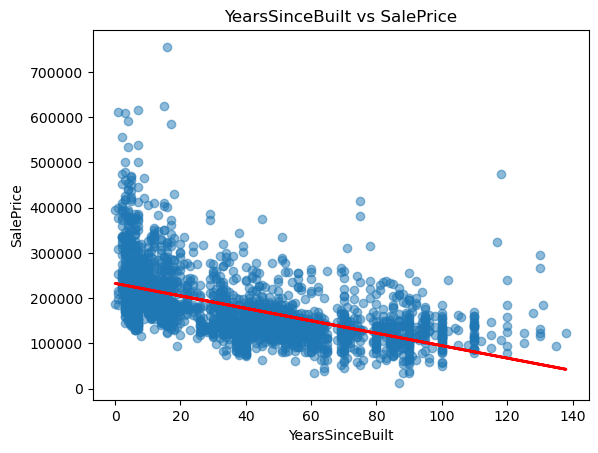

R^2 = 0.2965550613346397


In [225]:
# Plot and score YearSinceBuilt

# Fit the model
lr.fit(predictors[['YearsSinceBuilt']], target)

# Create scatter plot
plt.scatter(predictors['YearsSinceBuilt'], target, alpha=0.5)

# Plot the regression line
plt.plot(predictors['YearsSinceBuilt'], lr.predict(predictors[['YearsSinceBuilt']]), color='red', linewidth=2)

# Label the plot
plt.title('YearsSinceBuilt vs SalePrice')
plt.xlabel('YearsSinceBuilt')
plt.ylabel('SalePrice')

# Show the plot
plt.show()

# Show scores
print(f"R^2 = {lr.score(predictors[['YearsSinceBuilt']], target)}")

#### Condition proxy features

*Candidates*
- OverallQual: Rates the overall material and finish of the house
- OverallCond: Rates the overall condition of the house

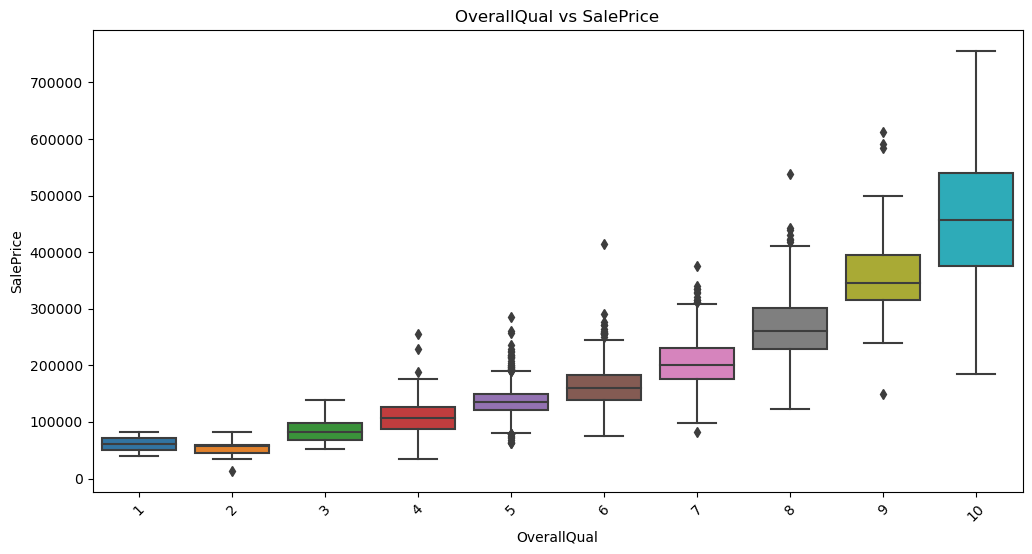

In [226]:
# Create a box plot of SalePrice vs. OverallQual
plt.figure(figsize=(12, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=ames_clean)

# Label the plot
plt.title('OverallQual vs SalePrice')
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [227]:
# Fit the model
lr.fit(predictors[['OverallQual']], target)

# Show the R^2 score
print(f"R^2 = {lr.score(predictors[['OverallQual']], target)}")

R^2 = 0.6251450369427116


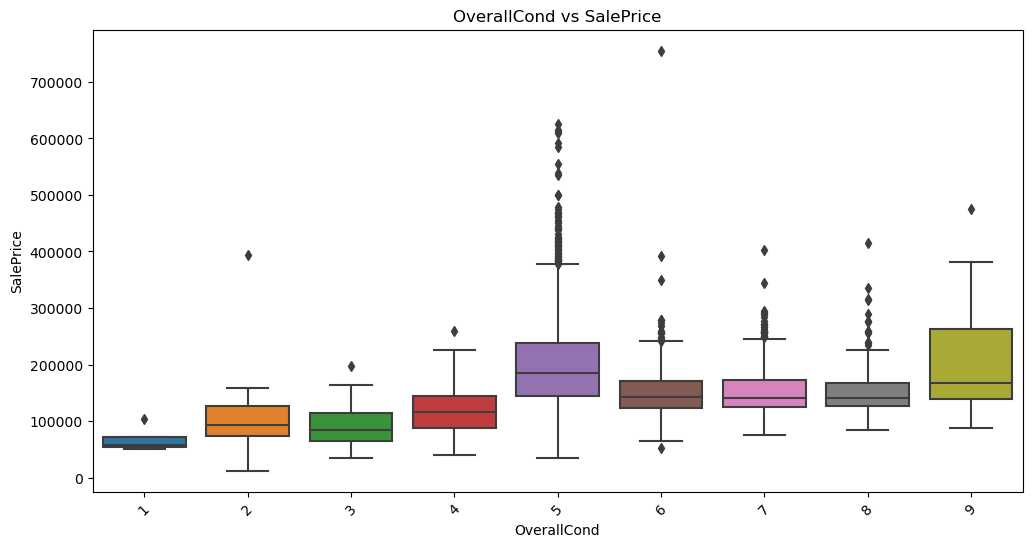

In [228]:
# Create a box plot of SalePrice vs. OverallCond
plt.figure(figsize=(12, 6))
sns.boxplot(x='OverallCond', y='SalePrice', data=ames_clean)

# Label the plot
plt.title('OverallCond vs SalePrice')
plt.xlabel('OverallCond')
plt.ylabel('SalePrice')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [229]:
# Fit the model
lr.fit(predictors[['OverallCond']], target)

# Show the R^2 score
print(f"R^2 = {lr.score(predictors[['OverallCond']], target)}")

R^2 = 0.010225789793399054


#### Upgrades and Updates proxy features

*Candidates:*
- YearSinceRemod: Years since Remodel date (same as construction date if no remodeling or additions)

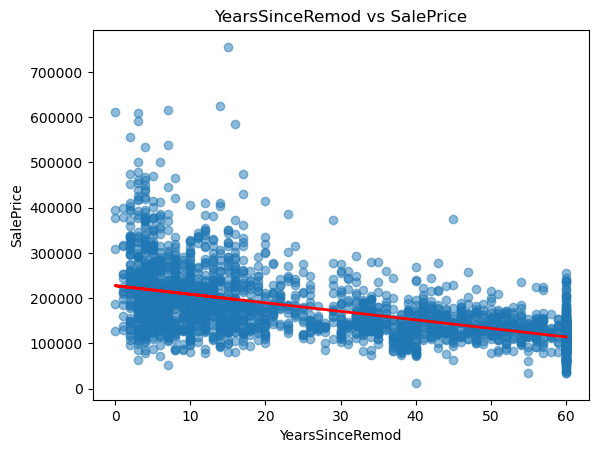

R^2 = 0.2649366345406384


In [231]:
# Plot and score YearsSinceRemod

# Fit the model
lr.fit(predictors[['YearsSinceRemod']], target)

# Create scatter plot
plt.scatter(predictors['YearsSinceRemod'], target, alpha=0.5)

# Plot the regression line
plt.plot(predictors['YearsSinceRemod'], lr.predict(predictors[['YearsSinceRemod']]), color='red', linewidth=2)

# Label the plot
plt.title('YearsSinceRemod vs SalePrice')
plt.xlabel('YearsSinceRemod')
plt.ylabel('SalePrice')

# Show the plot
plt.show()

# Show scores
print(f"R^2 = {lr.score(predictors[['YearsSinceRemod']], target)}")

#### Microeconomic and macroeconomic proxy features

*Candidates:*
- Crisis

<AxesSubplot:xlabel='Crisis', ylabel='SalePrice'>

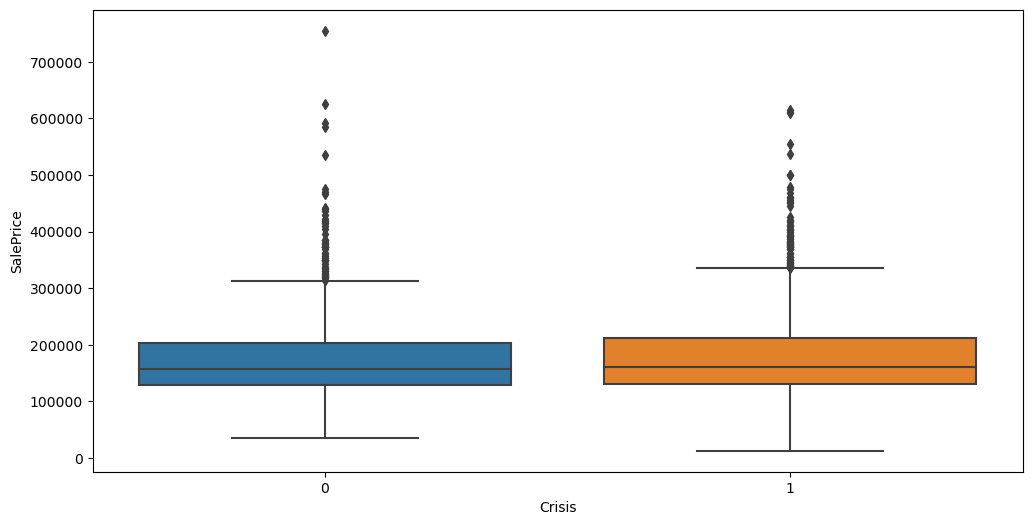

In [233]:
# Boxplot of SalePrice vs. crisis
plt.figure(figsize=(12, 6))
sns.boxplot(x='Crisis', y='SalePrice', data=data)

In [234]:
# Fit the model
lr.fit(predictors[['Crisis']], target)

# Print the R^2 score
lr.score(predictors[['Crisis']], target)

0.0002456458842525766

Our 'crisis' variable doesn't provide very much explanatory value.  Let's take a look at how pricing changes as a function of time e.g. stationarity.


In [236]:
# Combine MoSold and YrSold into a single 'Date' column
macro = pd.DataFrame()
macro['DateSold'] = pd.to_datetime(predictors['YrSold'].astype(str) + '-' + predictors['MoSold'].astype(str) + '-01')

# Create a quarterly 'Period' column reflecting the date
macro['Period'] = pd.PeriodIndex(macro.DateSold, freq='Q')

# Concatenate macro and target
macro = pd.concat([macro, target], axis=1)

# Check the output
print(macro.head())

    DateSold  Period  SalePrice
0 2010-03-01  2010Q1     126000
1 2009-02-01  2009Q1     139500
2 2007-11-01  2007Q4     124900
3 2009-05-01  2009Q2     114000
4 2009-11-01  2009Q4     227000


In [237]:
# Group by 'Period' and calculate the median 'SalePrice'
median_prices = macro.groupby('Period')['SalePrice'].median().reset_index()

# Create a custom sorting function
def custom_sort(period):
    year, quarter = period.split('Q')
    return int(quarter), int(year)

# Sort periods using the custom sorting function
median_prices['Period'] = pd.PeriodIndex(median_prices['Period'], freq='Q')
median_prices['sort_key'] = median_prices['Period'].astype(str).apply(custom_sort)
median_prices = median_prices.sort_values('sort_key').drop('sort_key', axis=1)

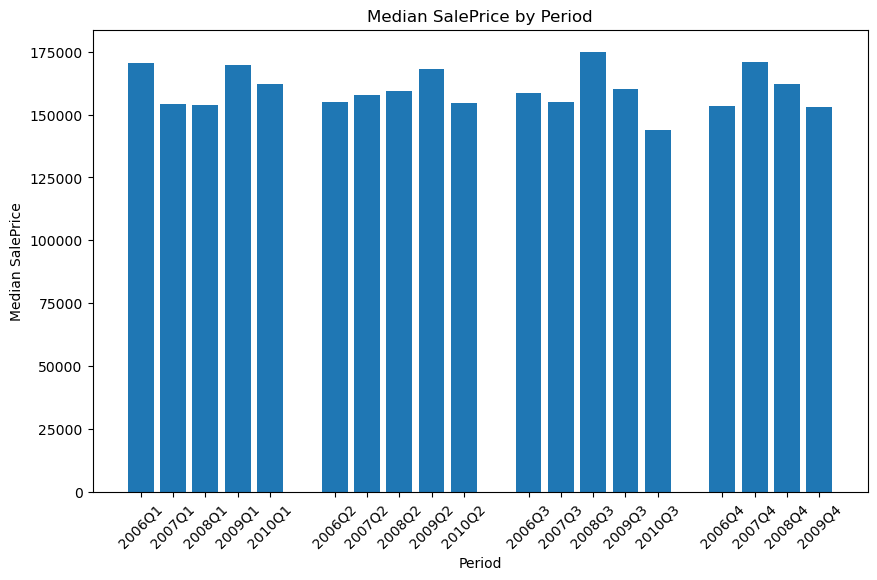

In [238]:
# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the new x-axis values with spaces between quarters
x_values = []
for i, period in enumerate(median_prices['Period']):
    x_val = i + i // 5
    x_values.append(x_val)

# Plot the bars with the new x-axis values
ax.bar(x_values, median_prices['SalePrice'])

# Label the plot
ax.set_title('Median SalePrice by Period')
ax.set_xlabel('Period')
ax.set_ylabel('Median SalePrice')

# Set the x-axis labels with the new x-axis values
ax.set_xticks(x_values)
ax.set_xticklabels(median_prices['Period'], rotation=45)

# Show the plot
plt.show()


#### Collect Significant Features

In [285]:
# Gather proxy variables from predictors
selected_features_small = predictors[['NeighborhoodCostIndex', 'GrLivArea', 'OverallQual']]

#### Check for Multicollinearity

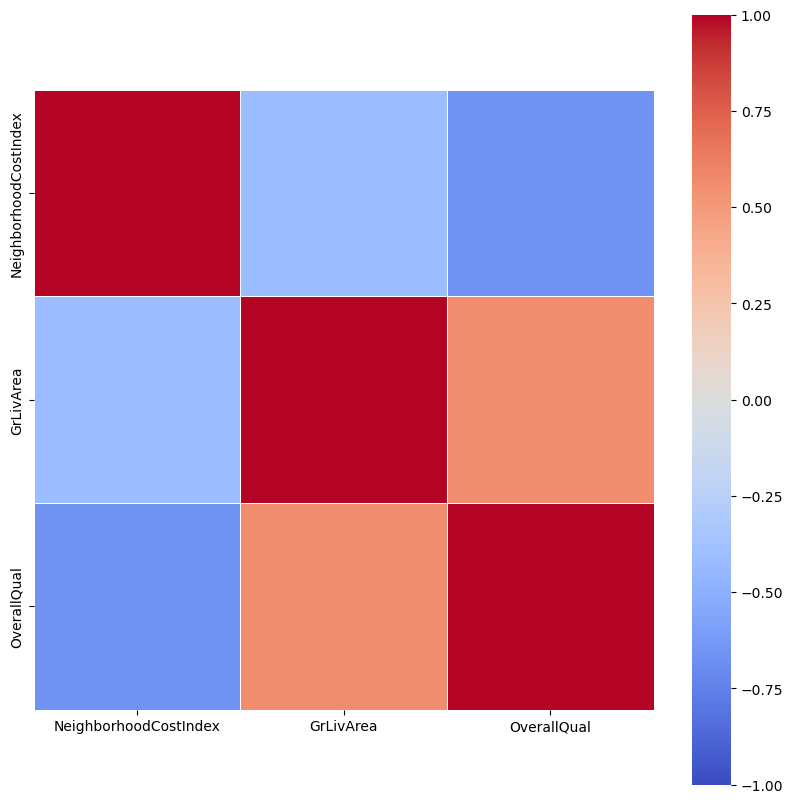

In [286]:
# Plot the correlation matrix
correlation_matrix = selected_features_small.corr()

plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, square=True, cmap='coolwarm', fmt='.2f', vmax=1.0, vmin=-1.0, linewidths=0.5)
plt.show()

In [287]:
# Calculate the VIF for each feature in the selected_features DataFrame
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(selected_features_small.values, i)
              for i in range(selected_features_small.shape[1])]

# Add the feature names to the VIF DataFrame
vif['Feature'] = selected_features_small.columns

# Sort the VIF DataFrame by VIF values in descending order
vif = vif.sort_values(by='VIF', ascending=False)

# Print the VIF DataFrame
print(vif)

         VIF                Feature
2  15.840754            OverallQual
1  14.701706              GrLivArea
0   3.008405  NeighborhoodCostIndex


## Split Data into Train-Test Sets

In [288]:
# Split the data into 80% train and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(selected_features_small, target, test_size=0.2, random_state=0)

## Train Model

In [290]:
# Use cross-validation on train data
cross_val_scores = cross_val_score(lr, X_train, y_train, cv=5)
print(f"Average 5-Fold CV Score: {np.mean(cross_val_scores)}")

Average 5-Fold CV Score: 0.7741493173298688


In [291]:
# Fit the model to the training data
lr.fit(X_train, y_train)

LinearRegression()

## Model Evaluation

In [292]:
# Display the metrics
print('R^2 on test set is equal to %.3f' %(lr.score(X_test, y_test)))
print('The intercept is equal to %.3f' %(lr.intercept_))
print('The slopes are %s' %(lr.coef_))

R^2 on test set is equal to 0.793
The intercept is equal to 10071.350
The slopes are [-2909.80306535    57.43677928 21054.12652489]


Text(0.5, 1.0, 'Distribution of Residuals')

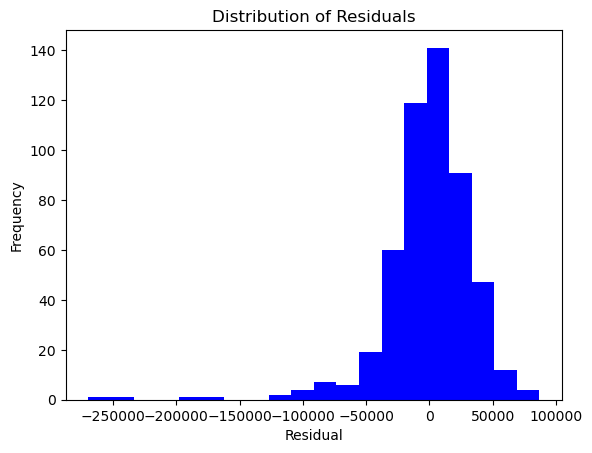

In [293]:
# Calculate the predictions on the test set
predictions = lr.predict(X_test)

# Calculate the residuals
residuals = predictions - y_test

# Plot a histogram of the residuals
plt.hist(residuals, bins=20, color='blue')

# Labels and title
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

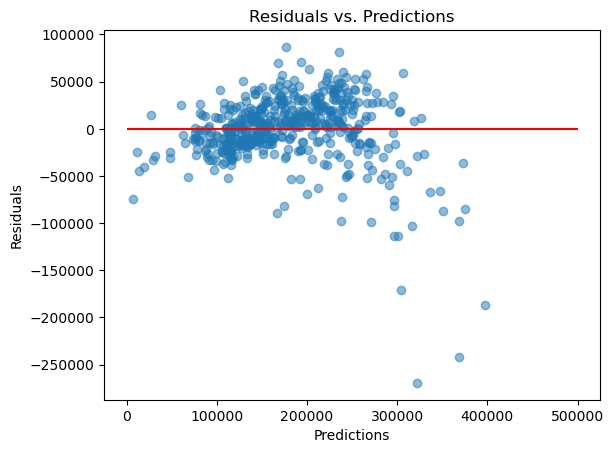

In [294]:
# Create the plot
plt.scatter(predictions, residuals, alpha=0.5)

# Labels and title
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predictions')

# Draw a horizontal line at y = 0
plt.hlines(y=0, xmin=0, xmax=500000, color='red')

# Show the plot
plt.show()

## Conclusion

We are able to get a decently accurate model using only three predictors:
- 'Neighborhood', indexed
- 'GrLivArea'
- 'OverallQual'

Our mantra could basically be: "Location, Size, Condition!"

We will use this as a "baseline" for accuracy and interpretability for other ML models.

<br>
<br>


> **"Einstein said something along the lines of 'Make things as simple as possible, and no simpler.'  That's probably Rule Number 1 of modelling.**  
> **Rule Number 2 would be 'If you are going to make things more complicated then do so one new feature at a time.'**  
> **Already that's a big difference to machine learning in which one tends to throw in everything at the start, including the kitchen sink."**  
>
> Paul Wilmott, *Machine Learning: An Applied Mathematics Introduction*